In [1]:
!pip install openpyxl

In [2]:
import mlfinlab
import pandas as pd
import numpy as np
import random
import yfinance as yf
from mlfinlab.portfolio_optimization.tic import TIC
from datetime import datetime, timedelta
import pypfopt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns,plotting,objective_functions
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from datetime import datetime,date
import calendar


In [3]:
def monthdelta(date, delta):
    m, y = (date.month+delta) % 12, date.year + ((date.month)+delta-1) // 12
    if not m: m = 12
    d = min(date.day, [31,
        29 if y%4==0 and (not y%100==0 or y%400 == 0) else 28,
        31,30,31,30,31,31,30,31,30,31][m-1])
    return date.replace(day=d,month=m, year=y)

In [4]:
europe_tickers = ["0P0000P1BG.F", "EXSA.DE", "0P00000RNA.F"]
data_eur = yf.download(" ".join(europe_tickers),period="max")
data_eur= data_eur["Adj Close"]
currency_eur = yf.download(" ".join([ "EURUSD=X "]), period = "max")
currency_eur = currency_eur["Adj Close"]


[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
for ticker in europe_tickers:
    data_eur[ticker] = data_eur[ticker] * currency_eur


In [6]:
portfolio_tickers = ["SPY", "LQD", "TLT"]

data_opt = yf.download(" ".join(portfolio_tickers),period="max")

data_opt = data_opt["Adj Close"]
for ticker in europe_tickers:
    data_opt[ticker] = data_eur[ticker]


[*********************100%***********************]  3 of 3 completed


In [7]:
data_opt.to_excel(r"C:\Users\Vannesa Nyathi\OneDrive - University of Bristol\MDM3\MDM3_data.xlsx", index = True)

In [8]:
path = (r"C:\Users\Vannesa Nyathi\OneDrive - University of Bristol\MDM3\MDM3_data.xlsx")
data_final = pd.read_excel(path,index_col = "Date")


In [9]:
def optimisation(data_opt, covariance):
    cleaned_weights = {}
    
    # Calculate the expected returns and covariance matrix based on that month
    mu = expected_returns.mean_historical_return(data_opt, frequency = len(data_opt))
    S = tic_covariances(data_opt)[covariance]
    # Optimise mean - variance to get weights for initialising investment process
    ef = EfficientFrontier(mu, S)
    #ef.add_objective(objective_functions.L2_reg, gamma = 1)
    try:
        raw_weights = ef.efficient_return(0.03)
    except:
        raw_weights = ef.efficient_return(np.abs(mu).max())
        #print("b")
    cleaned_weights = ef.clean_weights()
    return cleaned_weights, S

In [10]:
def fractional_profit(cleaned_weights,portfolio_value_updated,i,start_date,data,interval):
    monthly_earnings = 0
    j=0
    for key in cleaned_weights:
        nb_shares =(portfolio_value_updated/get_latest_prices(data.loc[:monthdelta(start_date, i+interval)])[j])
        price_diff = (get_latest_prices(data.loc[:monthdelta(start_date, i+2*interval)])[j] -get_latest_prices(data.loc[:monthdelta(start_date, i+interval)])[j])
        monthly_earnings += cleaned_weights[str(key)]*nb_shares *price_diff
        j = j +1
    return monthly_earnings


In [11]:
def tic_covariances(data_opt):
    
    #Country tree
    data2 = {"Ticker": ["TLT","SPY","LQD","0P0000P1BG.F", "EXSA.DE", "0P00000RNA.F"],
        "Country":[115,115,115,125,125,125],
       "Structure":[1,1,1,1,1,1]}
    df2 = pd.DataFrame(data2)
    
    
    #Asset type tree
    data = {"Ticker": ["TLT","SPY","LQD","0P0000P1BG.F", "EXSA.DE", "0P00000RNA.F"],
        "Asset Class":[215,225,235,215,225,235],
       "Structure":[2,2,2,2,2,2]}
    
    df = pd.DataFrame(data)
    

    
    stock_returns = expected_returns.mean_historical_return(data_opt, frequency = len(data_opt))
    daily_returns = expected_returns.returns_from_prices(data_opt, log_returns=False)
    
    std_ticker = []
    for key in range(stock_returns.shape[0]):
        std_ticker.append(daily_returns.iloc[:, key].std())
    corr_matrix = daily_returns.corr()
    tn_relation = daily_returns.shape[0] / daily_returns.shape[1]
    
    tic = TIC()
    tic_matrix = pd.DataFrame(tic.tic_correlation(df, corr_matrix, tn_relation, kde_bwidth=0.01))
    matrix_distance = tic.corr_dist(corr_matrix, tic_matrix)
    tic_cov = pypfopt.risk_models.corr_to_cov(tic_matrix,std_ticker)*len(data_opt)
    
    
    tic2 = TIC()
    tic_matrix_2 = pd.DataFrame(tic2.tic_correlation(df2, corr_matrix, tn_relation, kde_bwidth=0.01))
    matrix_distance2 = tic2.corr_dist(corr_matrix, tic_matrix_2)
    tic_cov2 = pypfopt.risk_models.corr_to_cov(tic_matrix_2,std_ticker)*len(data_opt)
    
    big_tic = (tic_matrix+tic_matrix_2)/2
    big_tic_cov = pypfopt.risk_models.corr_to_cov(big_tic,std_ticker)*len(data_opt)
    
    empirical_covariance = risk_models.sample_cov(data_opt, frequency=len(data_opt))
    
    return big_tic_cov, tic_cov, tic_cov2, empirical_covariance



In [12]:
def investment_simulation(data, start_date, end_date, covariance, portfolio_value=1000000, interval=1):
    i = -interval
    portfolio_value_updated = portfolio_value
    total_profit = 0
    monthly_profit = 0
    timer = True
    cleaned_weights = {}
    profit_values = []
    month_values = []
    cum_portfolio_value = []
    while timer:
        try:
            cleaned_weights = optimisation(data.loc[monthdelta(start_date,i):monthdelta(start_date,i+interval)],covariance)[0]
        except:
            for element in data.keys():
                cleaned_weights[element] = 1/data.shape[1]
        monthly_profit = fractional_profit(cleaned_weights,portfolio_value_updated,i,start_date,data,interval)
      

      
        month_values.append((i))
        profit_values.append((monthly_profit/portfolio_value)*100)
        cum_portfolio_value.append(portfolio_value_updated)
        portfolio_value_updated += monthly_profit
        i +=interval
        if monthdelta(start_date,i) == end_date:
            total_profit = portfolio_value_updated - portfolio_value
            timer = False
        cov = optimisation(data_opt, covariance)[1]

    return total_profit, profit_values, month_values, cov, cum_portfolio_value


In [13]:
#New data set
old_data = data_final.drop("0P00000RNA.F",1)
old_data.tail()

,LQD,SPY,TLT,0P0000P1BG.F,EXSA.DE
Date,,,,,
2020-11-17,136.639999,360.619995,158.809998,28.399806,45.629201
2020-11-18,136.929993,356.279999,159.270004,28.412286,45.853060
2020-11-19,137.690002,357.779999,160.089996,NaN,45.447544
2020-11-20,137.570007,355.329987,161.509995,28.453441,45.739336
2020-11-23,137.740005,357.529999,160.770004,NaN,45.626608


In [14]:
def tic_covariances_2(data_opt):
    
    #Country tree
    #Country tree
    data2 = {"Ticker": ["TLT","SPY","LQD","0P0000P1BG.F", "EXSA.DE"],
        "Country":[115,115,115,125,125],
       "Structure":[1,1,1,1,1]}
    df2 = pd.DataFrame(data2)
    
    
    #Asset type tree
    data = {"Ticker": ["TLT","SPY","LQD","0P0000P1BG.F", "EXSA.DE"],
        "Asset Class":[215,225,235,215,225],
       "Structure":[2,2,2,2,2],}
    df = pd.DataFrame(data)

    stock_returns = expected_returns.mean_historical_return(data_opt, frequency = len(data_opt))
    daily_returns = expected_returns.returns_from_prices(data_opt, log_returns=False)
    
    std_ticker = []
    for key in range(stock_returns.shape[0]):
        std_ticker.append(daily_returns.iloc[:, key].std())
    corr_matrix = daily_returns.corr()
    tn_relation = daily_returns.shape[0] / daily_returns.shape[1]
    
    tic = TIC()
    tic_matrix = pd.DataFrame(tic.tic_correlation(df, corr_matrix, tn_relation, kde_bwidth=0.01))
    matrix_distance = tic.corr_dist(corr_matrix, tic_matrix)
    tic_cov = pypfopt.risk_models.corr_to_cov(tic_matrix,std_ticker)*len(data_opt)
    
    
    tic2 = TIC()
    tic_matrix_2 = pd.DataFrame(tic2.tic_correlation(df2, corr_matrix, tn_relation, kde_bwidth=0.01))
    matrix_distance2 = tic2.corr_dist(corr_matrix, tic_matrix_2)
    tic_cov2 = pypfopt.risk_models.corr_to_cov(tic_matrix_2,std_ticker)*len(data_opt)
    
    big_tic = (tic_matrix+tic_matrix_2)/2
    big_tic_cov = pypfopt.risk_models.corr_to_cov(big_tic,std_ticker)*len(data_opt)
    
    empirical_covariance = risk_models.sample_cov(data_opt, frequency = len(data_opt))
    
    return big_tic_cov, tic_cov, tic_cov2, empirical_covariance

In [15]:
def optimisation_2(data_opt, covariance):
    cleaned_weights = {}
    
    # Calculate the expected returns and covariance matrix based on that month
    mu = expected_returns.mean_historical_return(data_opt, frequency = len(data_opt))
    S = tic_covariances_2(data_opt)[covariance]
    # Optimise mean - variance to get weights for initialising investment process
    ef = EfficientFrontier(mu, S)
    #ef.add_objective(objective_functions.L2_reg, gamma = 1)
    try:
        raw_weights = ef.efficient_return(0.03)
    except:
        raw_weights = ef.efficient_return(np.abs(mu).max())
        #print("b")
    cleaned_weights = ef.clean_weights()
    return cleaned_weights, S

In [16]:
def investment_simulation_2(data, start_date, end_date, covariance, portfolio_value=1000000, interval=1):
    i = -interval
    portfolio_value_updated = portfolio_value
    total_profit = 0
    monthly_profit = 0
    timer = True
    cleaned_weights = {}
    profit_values = []
    month_values = []
    cum_portfolio_value = []
    t = 0
    while timer:
        try:
            cleaned_weights = optimisation_2(data.loc[monthdelta(start_date,i):monthdelta(start_date,i+interval)],covariance)[0]
          
        except:
            t = t+1
            for element in portfolio_tickers:
                cleaned_weights[element] = 1/len(portfolio_tickers)
        monthly_profit = fractional_profit(cleaned_weights,portfolio_value_updated,i,start_date,data,interval)
        portfolio_value_updated += monthly_profit
      
        month_values.append((i))
        profit_values.append((monthly_profit/portfolio_value)*100)
        cum_portfolio_value.append(portfolio_value_updated)
        i +=interval
        if monthdelta(start_date,i) == end_date:
            total_profit = portfolio_value_updated - portfolio_value
            timer = False
    
        cov = optimisation(data_opt, covariance)[1]


    return total_profit, profit_values, month_values, cov, cum_portfolio_value


In [17]:
total_profits_old0, monthly_profits_old0, month_old0, covariance_old0,cum_portfolio_value_old0 = investment_simulation_2(old_data,date(2012, month = 8, day = 3),
                        date(year = 2018, month = 1, day = 3) , 0,1000000, interval=1)
total_profits_old1, monthly_profits_old1, month_old1, covariance_old1,cum_portfolio_value_old1 = investment_simulation_2(old_data,date(2012, month = 8, day = 3),
                        date(year = 2018, month = 1, day = 3) , 1,1000000, interval=1)
total_profits_old2, monthly_profits_old2, month_old2, covariance_old2,cum_portfolio_value_old2 = investment_simulation_2(old_data,date(2012, month = 8, day = 3),
                        date(year = 2018, month = 1, day = 3) , 2,1000000, interval=1)
total_profits_old3, monthly_profits_old3, month_old3, covariance_old3,cum_portfolio_value_old3 = investment_simulation_2(old_data,date(2012, month = 8, day = 3),
                        date(year = 2018, month = 1, day = 3) , 3,1000000, interval=1)

In [18]:
#covariance argument: 0 is for big_tic_cov, 1 is for asset type_covariance, 2 is for country_covariance, 3 is for empirical_covariance 


total_profits0, monthly_profits0, month0, covariance0,cum_portfolio_value0 = investment_simulation(data_final,date(2018, month = 1, day = 3),
                        date(year = 2020, month = 11, day = 3) , 0,1000000+total_profits_old0, interval=1)
total_profits1, monthly_profits1, month1, covariance1,cum_portfolio_value1 = investment_simulation(data_final,date(2018, month = 1, day = 3),
                        date(year = 2020, month = 11, day = 3),
                        1,1000000+total_profits_old1,  interval=1)
total_profits2, monthly_profits2, month2, covariance2,cum_portfolio_value2 = investment_simulation(data_final,date(2018, month = 1, day = 3),
                        date(year = 2020, month = 11, day = 3),
                        2,1000000+total_profits_old2,  interval=1)
total_profits3, monthly_profits3, month3, covariance3,cum_portfolio_value3 = investment_simulation(data_final,date(2018, month = 1, day = 3),
                        date(year = 2020, month = 11, day = 3),
                        3,1000000+total_profits_old3,  interval=1)

In [19]:
#Months of our investment period : 03/08/2012 to 03/11/2020 (date when EXSA.DE starts giving daily values -- "0P00000RNA.F" starts in january 2018)
i = 1
nb_years = 9

year = 12
month_list = []
for t in range(0,nb_years):
    for month in calendar.month_name[1:]:
        a = str(i)+"/" + str(year)
        month_list.append(a)
        i = i +1
        
        if i % 13 == 0:
            year+=1
            i=1
our_month_list = month_list[7:-1]

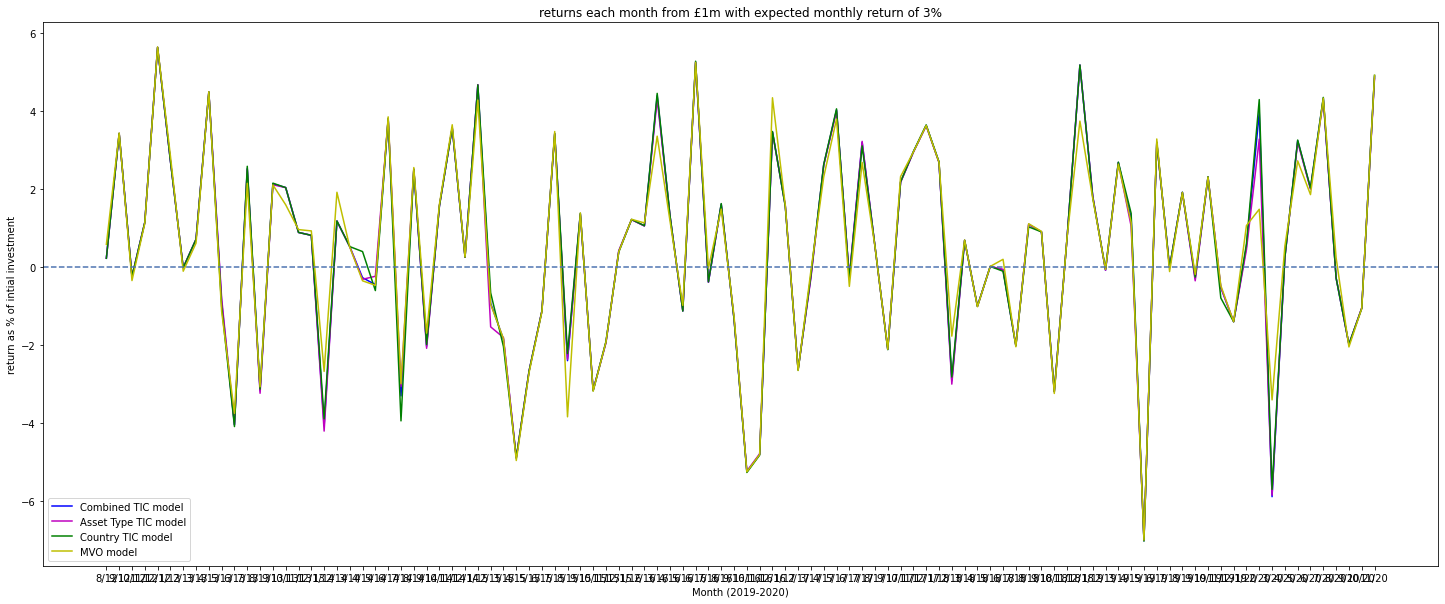

In [20]:
import matplotlib.pyplot as plt

#import calendar
#months = {1 + (i-10) % 12:calendar.month_name[i] for i in range(0, 12)}
#print(months, month0) #numbers correspond to month

plt.figure(figsize=(25, 10))
line0 = plt.plot(our_month_list,monthly_profits_old0 + monthly_profits0[1:], 'b', label='Combined TIC model')
line1 = plt.plot(our_month_list, monthly_profits_old1 + monthly_profits1[1:], 'm', label='Asset Type TIC model')
line2 = plt.plot(our_month_list, monthly_profits_old2 + monthly_profits2[1:], 'g', label='Country TIC model')
line3 = plt.plot(our_month_list, monthly_profits_old3 + monthly_profits3[1:], 'y', label='MVO model')
plt.title('returns each month from £1m with expected monthly return of 3%')
plt.xlabel('Month (2019-2020)')
plt.ylabel('return as % of intial investment')

plt.axhline(0,linestyle = "--")

plt.legend()
plt.show()

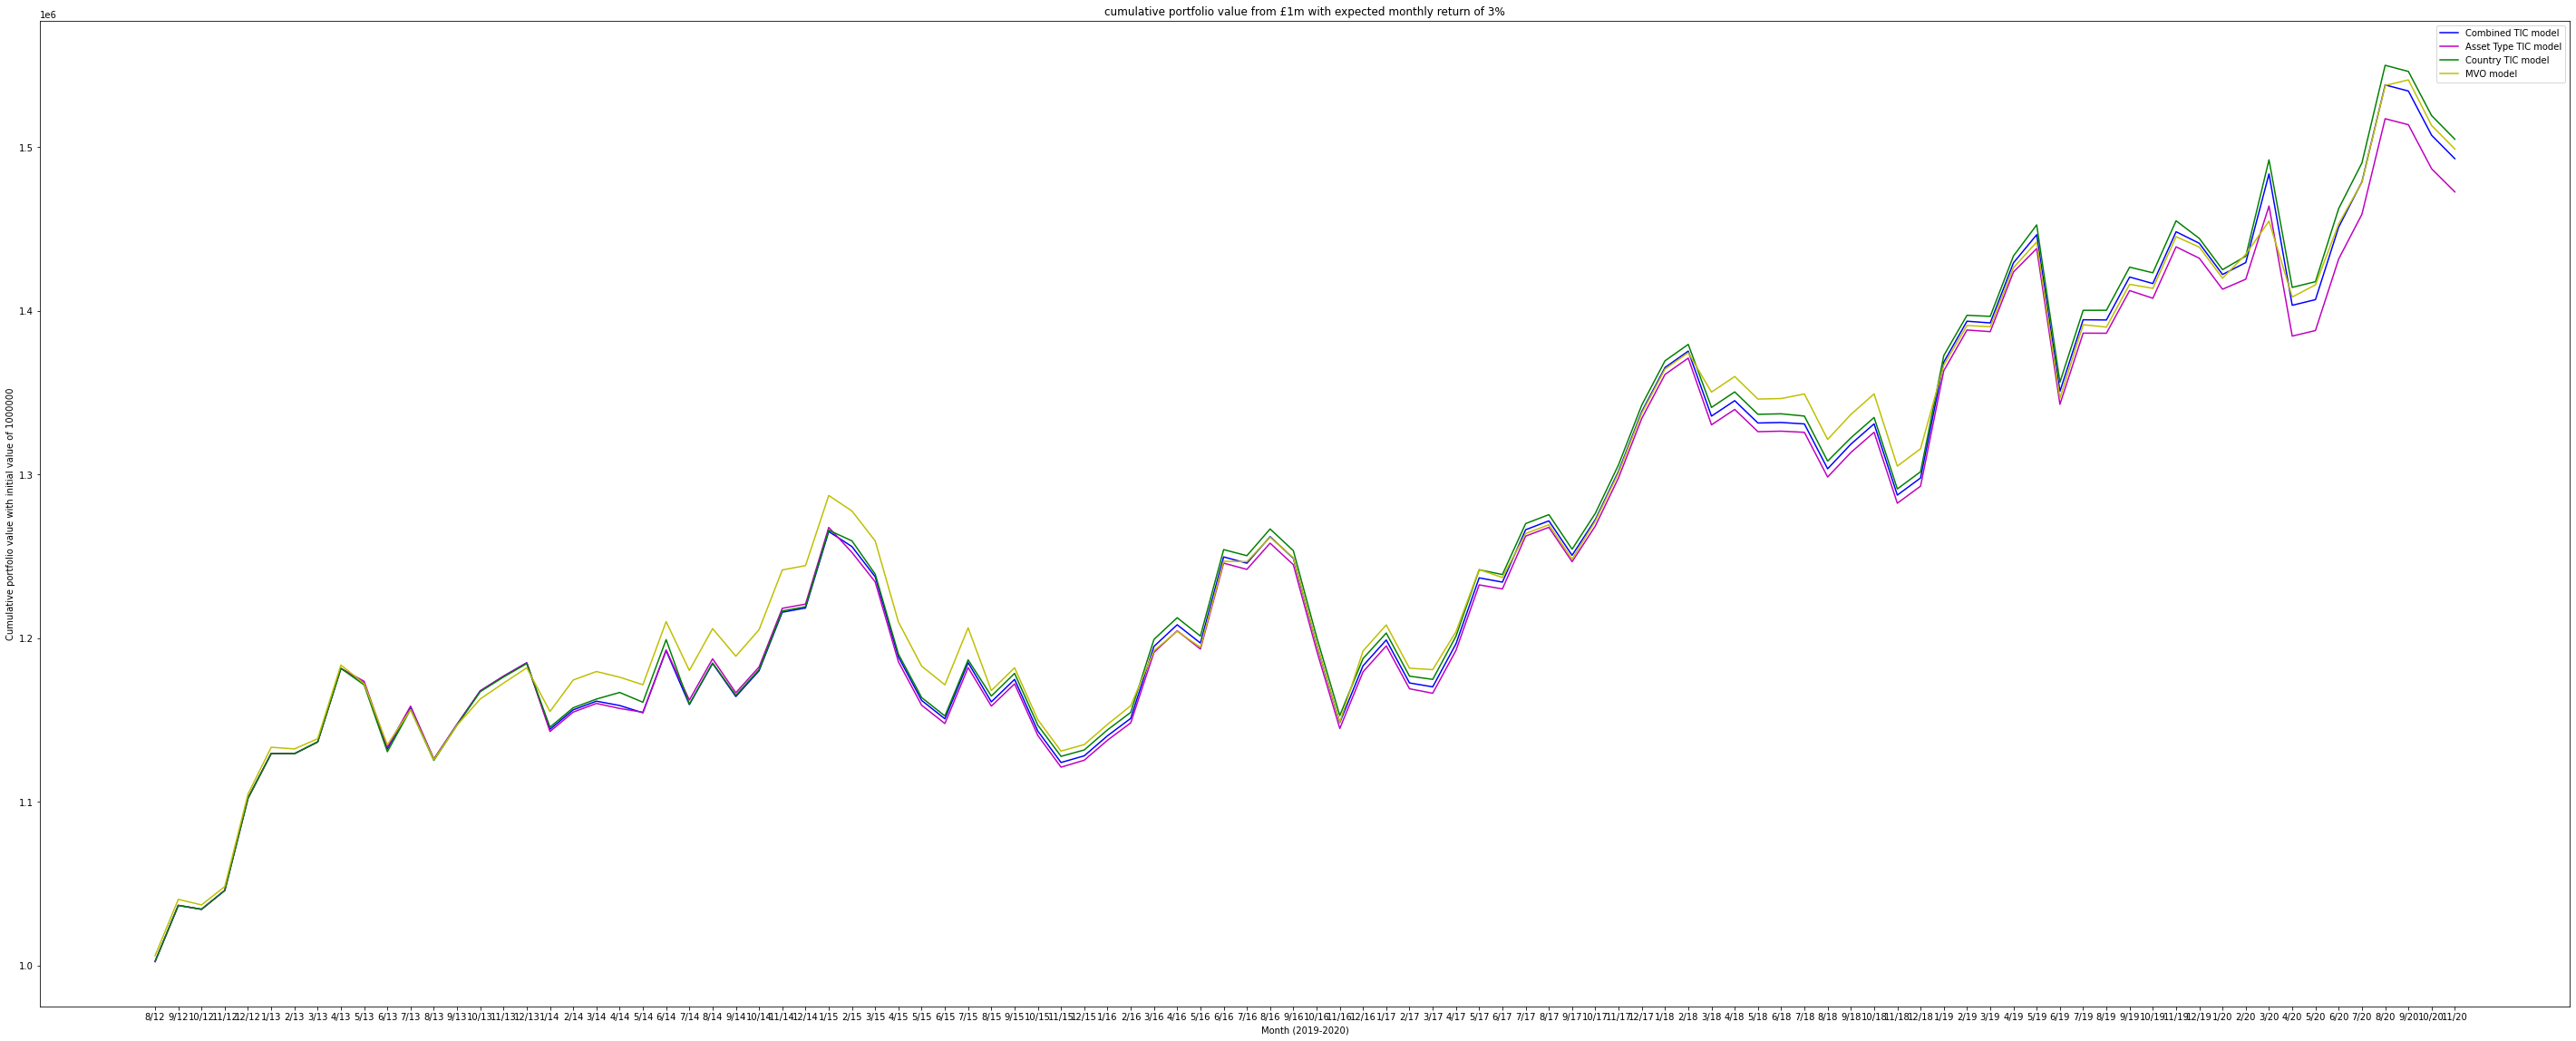

Combined 559808.2609211416
Asset class 538608.2832796804
Country 572239.3194594532
MVO 565990.531666477


In [21]:
#import calendar
#months = {1 + (i-10) % 12:calendar.month_name[i] for i in range(0, 12)}
#print(months, month0) #numbers correspond to month


plt.figure(figsize=(50, 20))
line0 = plt.plot(our_month_list, cum_portfolio_value_old0 + cum_portfolio_value0[1:], 'b', label='Combined TIC model')
line1 = plt.plot(our_month_list,cum_portfolio_value_old1 + cum_portfolio_value1[1:], 'm', label='Asset Type TIC model')
line2 = plt.plot(our_month_list, cum_portfolio_value_old2 + cum_portfolio_value2[1:], 'g', label='Country TIC model')
line3 = plt.plot(our_month_list, cum_portfolio_value_old3 + cum_portfolio_value3[1:], 'y', label='MVO model')
#line4 = plt.plot(months_str, diff, 'y', label='MVO model')
plt.title('cumulative portfolio value from £1m with expected monthly return of 3%')
plt.xlabel('Month (2019-2020)')
plt.ylabel('Cumulative portfolio value with initial value of 1000000')



plt.legend()
plt.show()
print("Combined",total_profits_old0 +total_profits0)
print("Asset class",total_profits_old1 + total_profits1)
print("Country",total_profits_old2 +total_profits2)
print("MVO",total_profits_old3 +total_profits3)

In [22]:
#plotting the efficient frontier


In [23]:
#END_DATE = datetime.today() - timedelta(days = 1) #END_DATE is set to yesterday
#d = data_final.loc[monthdelta(END_DATE,-12):monthdelta(END_DATE,-11)]
#stock_returns = expected_returns.mean_historical_return(d, frequency = len(d))
#plot_efficient_frontier(stock_returns, tic_covariances(d)[3], 10, 'test')
#plot_efficient_frontier(stock_returns, tic_covariances(d)[2], 10, 'test')
#plot_efficient_frontier(stock_returns, tic_covariances(d)[1], 10, 'test')
#plot_efficient_frontier(stock_returns, tic_covariances(d)[0], 10, 'test')